# Exercise 5.12 Racetrack from the Reinforcement Learning textbook

- toc: true
- badges: true
- comments: true
- categories: [en]

Here I demonstrate the execise 5.12 of the textbook [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Richard Sutton and Andrew G. Barto, using both of planning method and Monte Carlo method.
Basic knowledge of Python (>= 3.7) and [NumPy](https://numpy.org/) are assumed.
Some konwledge of [matplotlib](https://matplotlib.org/) and [Python typing library](https://docs.python.org/3/library/typing.html) also helps.

Contact: `yuji.kanagawa@oist.jp`

## Modeling the problem in code

Let's start from writing the problem in code.
What are important in this phase?
Here, I'd like to emphasize the importantness of looking back at the definition of the environment.
I.e., in reinforcement learning (RL), environments are modelled by Markov decision process (MDP), consisting of **states, actions, transition function, and reward function**.
So first let's check the definition of **states** and **actions** in the problem statement.
It's (somehow) not very straightforward, but we can find
> In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step.

So, a state consists of **position** and **velocity** of the car (a.k.a. agent).
What about actions?

> The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in each step, for a total of nine ($3 \times 3$) actions.

So there are 9 actions for each direction (↓↙←↖↑↗→↘ or no acceleration).
Here, we can also notice that the total number of states is given by $\textrm{Num. positions} \times \textrm{Num. choices of velocity}$.
And the texbook also says
> Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line.

So there are 24 possible velocity at the non-starting positions:

In [1]:
import itertools
list(itertools.product(range(5), range(5)))[1:]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

Again, number of states is given by (roughly) $24 \times \textrm{Num. positions}$ and number of actions is $9$.
Sounds not very easy problem with many positions.

So, let's start the coding from representing the state and actions.
There are multiple ways, but I prefer to NumPy array for representing everything.

Let's consider a ASCII representation of the map (or track) like this:

In [2]:
SMALL_TRACK = """
###      F
##       F
##       F
#      ###
#      ###
#      ###
#SSSSS####
"""

Here, `S` denotes a starting positiona, `F` denotes a finishing position, `#` denotes a wall, and ` ` denotes a road.
We have this track as a 2D NumPy Array, and encode agent's position as an index of this array.

In [3]:
import numpy as np

def ascii_to_array(ascii_track: str) -> np.ndarray:
    """Convert the ascii (string) map to a NumPy array."""

    lines = [line for line in ascii_track.split("\n") if len(line) > 0]
    byte_lines = [list(bytes(line, encoding="utf-8")) for line in lines]
    return np.array(byte_lines, dtype=np.uint8)

track = ascii_to_array(SMALL_TRACK)
print(track)
position = np.array([0, 0])
track[tuple(position)] == int.from_bytes(b'#', "big")

[[35 35 35 32 32 32 32 32 32 70]
 [35 35 32 32 32 32 32 32 32 70]
 [35 35 32 32 32 32 32 32 32 70]
 [35 32 32 32 32 32 32 35 35 35]
 [35 32 32 32 32 32 32 35 35 35]
 [35 32 32 32 32 32 32 35 35 35]
 [35 83 83 83 83 83 35 35 35 35]]


True

Then, agent's velocity and acceleration are also naturally represented by an array.
And, we represent an action as an index of an array consisting of all possible acceleration vetors:

In [4]:
np.array(list(itertools.product([-1, 0, 1], [-1, 0, 1])))

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

The next step is to represent a transition function as a **black box simulator**.
Note that we will visit another representation by **transition matrix**, but implementing the simulator is easier.
Basically, the simulator should take an agent's action and current state, and then return the next state.
Let's call this function `step`.
However, let's make it return some other things to make the implementation easier.
Reward function sounds fairly easy to implement given the agent's position.
> The rewards are −1 for each step until the car crosses the finish line.

Also, we have to handle the *termination* of the episode.
> Each episode begins in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line.

So the resulting `step` function should return a tuple `(state, reward, termination)`.
The below cell contains my implementation of the simulator with matplotlib visualization.
The `step` function is so complicated to handle the case where the agent goes through a wall, so readers are encouraged to just run their eyes through.

State(position=array([6, 5]), velocity=array([0, 0]))


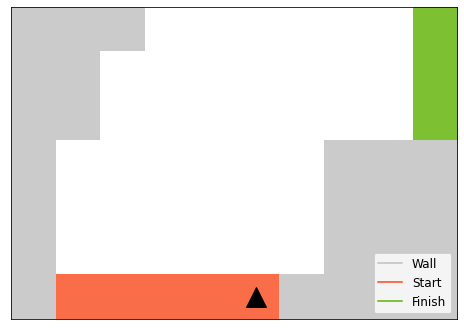

State(position=array([5, 5]), velocity=array([1, 0]))


<AxesSubplot:>

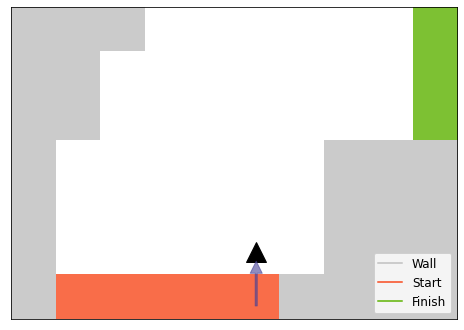

In [5]:
# collapse-hide

from typing import List, NamedTuple, Optional, Tuple

from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap


class State(NamedTuple):
    position: np.ndarray
    velocity: np.ndarray


class RacetrackEnv:
    """Racetrack environment"""

    EMPTY = int.from_bytes(b" ", "big")
    WALL = int.from_bytes(b"#", "big")
    START = int.from_bytes(b"S", "big")
    FINISH = int.from_bytes(b"F", "big")

    def __init__(
        self,
        ascii_track: str,
        noise_prob: float = 0.1,
        seed: int = 0,
    ) -> None:
        self._track = ascii_to_array(ascii_track)
        self._max_height, self._max_width = self._track.shape
        self._noise_prob = noise_prob
        self._actions = np.array(list(itertools.product([-1, 0, 1], [-1, 0, 1])))
        self._no_accel = 4
        self._random_state = np.random.RandomState(seed=seed)
        self._start_positions = np.argwhere(self._track == self.START)
        self._state_indices = None
        self._ax = None
        self._agent_fig = None
        self._arrow_fig = None
        
    def state_index(self, state: State) -> int:
        """Returns a state index"""
        (y, x), (vy, vx) = state
        return y * self._max_width * 25 + x * 25 + vy * 5 + vx
        

    def _all_passed_positions(
        self,
        start: np.ndarray,
        velocity: np.ndarray,
    ) -> Tuple[List[np.ndarray], bool]:
        """
        List all positions that the agent passes over.
        Here we assume that the y-directional velocity is already flipped by -1.
        """

        maxv = np.max(np.abs(velocity))
        if maxv == 0:
            return [start], False
        one_step_vector = velocity / maxv
        pos = start + 0.0
        traj = []
        for i in range(maxv):
            pos = pos + one_step_vector
            ceiled = np.ceil(pos).astype(int)
            if self._is_out(ceiled):
                return traj, True
            traj.append(ceiled)
        # To prevent numerical issue
        traj[-1] = start + velocity
        return traj, False

    def _is_out(self, position: np.ndarray) -> bool:
        """Returns whether the given position is out of the map."""
        y, x = position
        return y < 0 or x >= self._max_width

    def step(self, state: State, action: int) -> Tuple[State, float, bool]:
        """
        Taking the current state and an agents' action, returns the next state,
        reward and a boolean flag that indicates that the current episode terminates.
        """
        position, velocity = state
        if self._random_state.rand() < self._noise_prob:
            accel = self._actions[self._no_accel]
        else:
            accel = self._actions[action]
        # velocity is clipped so that only ↑→ directions are possible
        next_velocity = np.clip(velocity + accel, a_min=0, a_max=4)
        # If both of velocity is 0, cancel the acceleration
        if np.sum(next_velocity) == 0:
            next_velocity = velocity
        # List up trajectory. y_velocity is flipped to adjust the coordinate system.
        traj, went_out = self._all_passed_positions(
            position,
            next_velocity * np.array([-1, 1]),
        )
        passed_wall, passed_finish = False, False
        for track in map(lambda pos: self._track[tuple(pos)], traj):
            passed_wall |= track == self.WALL
            passed_finish |= track == self.FINISH
        if not passed_wall and passed_finish:  # Goal!
            return State(traj[-1], next_velocity), 0, True
        elif passed_wall or went_out:  # Crasshed to the wall or run outside
            return self.reset(), -1.0, False
        else:
            return State(traj[-1], next_velocity), -1, False

    def reset(self) -> State:
        """Randomly assigns a start position of the agent."""
        n_starts = len(self._start_positions)
        initial_pos_idx = self._random_state.choice(n_starts)
        initial_pos = self._start_positions[initial_pos_idx]
        initial_velocity = np.array([0, 0])
        return State(initial_pos, initial_velocity)

    def render(
        self,
        state: Optional[State] = None,
        movie: bool = False,
        ax: Optional[Axes] = None,
    ) -> Axes:
        """Render the map and (optinally) the agents' position and velocity."""
        if self._ax is None or ax is not None:
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])
            # Map the track to one of [0, 1, 2, 3] to that simple colormap works
            map_array = np.zeros_like(track)
            symbols = [self.EMPTY, self.WALL, self.START, self.FINISH]
            for i in range(track.shape[0]):
                for j in range(track.shape[1]):
                    map_array[i, j] = symbols.index(self._track[i, j])
            cm = ListedColormap(
                ["w", ".75", "xkcd:reddish orange", "xkcd:kermit green"]
            )
            map_img = ax.imshow(
                map_array,
                cmap=cm,
                vmin=0,
                vmax=4,
                alpha=0.8,
            )
            if ax.get_legend() is None:
                descriptions = ["Empty", "Wall", "Start", "Finish"]
                for i in range(1, 4):
                    if np.any(map_array == i):
                        ax.plot([0.0], [0.0], color=cm(i), label=descriptions[i])
                ax.legend(fontsize=12, loc="lower right")
            self._ax = ax
        if state is not None:
            if not movie and self._agent_fig is not None:
                self._agent_fig.remove()
            if not movie and self._arrow_fig is not None:
                self._arrow_fig.remove()
            pos, vel = state
            self._agent_fig = self._ax.plot(pos[1], pos[0], "k^", markersize=20)[0]
            # Show velocity
            self._arrow_fig = self._ax.annotate(
                "",
                xy=(pos[1], pos[0] + 0.2),
                xycoords="data",
                xytext=(pos[1] - vel[1], pos[0] + vel[0] + 0.2),
                textcoords="data",
                arrowprops={"color": "xkcd:blueberry", "alpha": 0.6, "width": 2},
            )
        return self._ax


smalltrack = RacetrackEnv(SMALL_TRACK)
state = smalltrack.reset()
print(state)
display(smalltrack.render(state=state).get_figure())
next_state, reward, termination = smalltrack.step(state, 7)
print(next_state)
smalltrack.render(state=next_state)

Note that the vertical velocity is negative, so that we can simply represent the coordinate by an array index.

## Solve a small problem by dynamic programming

OK, now we have a simulator, so let's solve the problem!
However, before stepping into reinforcement learning, it's better to compute an optimal policy in a small problem for sanity check.
To do so, we need a transition matrix `p`, which is a $|\mathcal{S}| \times |\mathcal{A}| \times |\mathcal{S}|$ NumPy array where `p[i][j][k]` is the probability of transiting from `i` to `k` when action `j` is taken.
Also, we need a $|\mathcal{S}| \times |\mathcal{A}| \times |\mathcal{S}|$ reward matrix `r`.
Note that this representation is not general as $R_t$ can be stochastic, but since the only stochasticity of rewards is the noise to actions in this problem, this notion suffices.
It is often not very straightforward to get `p` and `r` from the problem definition, but basically we need to give 0-indexd indices to each state (`0, 1, 2, ...`) and fill the array.
Here, I index each state by $\textrm{Idx(S)} = y \times 25 \times W + x \times 25 + vy \times 5 + vx$, where $(x, y)$ is a position, $(vx, vy$) is a velocity, and $W$ is the width of the map.

In [6]:
# collapse-hide
from typing import Iterable


def get_p_and_r(env: RacetrackEnv) -> Tuple[np.ndarray, np.ndarray]:
    """Taking RacetrackEnv, returns the transition probability p and reward fucntion r of the env."""
    n_states = env._max_height * env._max_width * 25
    n_actions = len(env._actions)
    p = np.zeros((n_states, n_actions, n_states))
    r = np.ones((n_states, n_actions, n_states)) * -1
    noise = env._noise_prob

    def state_prob(*indices):
        """Returns a |S| length zero-initialized array where specified elements are filled"""
        prob = 1.0 / len(indices)
        res = np.zeros(n_states)
        for idx in indices:
            res[idx] = prob
        return res

    # List up all states and memonize starting states
    states = []
    starting_states = []
    for y in range(env._max_height):
        for x in range(env._max_width):
            track = env._track[y][x]
            for y_velocity in range(5):
                for x_velocity in range(5):
                    state = State(np.array([y, x]), np.array([y_velocity, x_velocity]))
                    states.append(state)
                    if track == env.START:
                        starting_states.append(env.state_index(state))

    for state in states:
        position, velocity = state
        i = env.state_index(state)
        track = env._track[tuple(position)]
        # At a terminating state or unreachable, the agent cannot move
        if (
            track == env.FINISH
            or track == env.WALL
            or (np.sum(velocity) == 0 and track != env.START)
        ):
            r[i] = 0
            p[i, :] = state_prob(i)
        # Start or empty states
        else:
            # First, compute next state probs without noise
            next_state_prob = []
            for j, action in enumerate(env._actions):
                next_velocity = np.clip(velocity + action, a_min=0, a_max=4)
                if np.sum(next_velocity) == 0:
                    next_velocity = velocity
                traj, went_out = env._all_passed_positions(
                    position,
                    next_velocity * np.array([-1, 1]),
                )
                passed_wall, passed_finish = False, False
                for track in map(lambda pos: env._track[tuple(pos)], traj):
                    passed_wall |= track == env.WALL
                    passed_finish |= track == env.FINISH
                if passed_wall or (went_out and not passed_finish):
                    #  Run outside or crasheed to the wall
                    next_state_prob.append(state_prob(*starting_states))
                else:
                    next_state_idx = env.state_index(State(traj[-1], next_velocity))
                    next_state_prob.append(state_prob(next_state_idx))
                    if passed_finish:
                        r[i, j, next_state_idx] = 0.0
            # Then linearly mix the transition probs with noise
            for j in range(n_actions):
                p[i][j] = (
                    noise * next_state_prob[env._no_accel]
                    + (1.0 - noise) * next_state_prob[j]
                )

    return p, r

Then, let's compute the optimal Q value by value iteration.
So far, we only learned dynamic programming with discount factor $\gamma$, so let's use $\gamma =0.95$ that is sufficiently large for this small problem.
$\epsilon = 0.000001$ is used as a convergence threshold.
Let's show the elapsed time and the required number of iteration.

In [7]:
import datetime


class ValueIterationResult(NamedTuple):
    q: np.ndarray
    v: np.ndarray
    elapsed: datetime.timedelta
    n_iterations: int


def value_iteration(
    p: np.ndarray,
    r: np.ndarray,
    discount: float,
    epsilon: float = 1e-6,
) -> ValueIterationResult:
    n_states, n_actions, _ = p.shape
    q = np.zeros((n_states, n_actions))
    v = np.zeros(n_states)
    n_iterations = 0
    start = datetime.datetime.now()
    while True:
        n_iterations += 1
        v_old = v.copy()
        for s in range(n_states):
            # Q(s, a) = ∑ p(s, a, s') * (r(s, a, s') + γ v(s')
            for a in range(n_actions):
                q[s, a] = np.dot(p[s, a], r[s, a] + discount * v)
            # V(s) = max_a Q(s, a)
            v[s] = np.max(q[s])
        if np.linalg.norm(v - v_old, ord=np.inf) < epsilon:
            break
    return ValueIterationResult(q, v, datetime.datetime.now() - start, n_iterations)


p, r = get_p_and_r(smalltrack)
vi_result = value_iteration(p, r, discount=0.95)
print(f"Elapsed: {vi_result.elapsed.total_seconds()} n_iter: {vi_result.n_iterations}")

Elapsed: 1.196624 n_iter: 10


It took longer that a second on my laptop, even for this small problem.
Some technical notes on value iteration ($R_\textrm{max} = 1.0$ is assumed for simplicity):
- Each iteration takes $O(|\mathcal{S}| ^ 2 |\mathcal{A}|)$ time
- The required iteration number is bounded by $\frac{\log \epsilon}{\gamma - 1}$
  - In our case, $\frac{\log \epsilon}{\gamma - 1} \approx 270$, so our computation converged quicker than theory
  - Thus the total computation time is bounded by $O(|\mathcal{S}| ^ 2 |\mathcal{A}|\frac{\log \epsilon}{\gamma - 1})$
- For a convergence threshold $\epsilon$, $\max |V(s) - V^*(s)| < \frac{\gamma\epsilon}{1 - \gamma}$ is guranteed
  - In our case, $\frac{\gamma\epsilon}{1 - \gamma} \approx 0.00002$
  - This is called *relative error*

Let's visualize the V value and an optimal trajectory.
[celluloid)](https://github.com/jwkvam/celluloid) is used for making an animation.

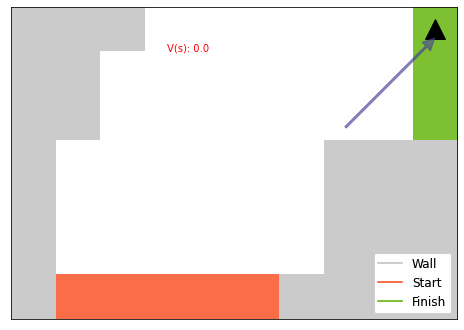

In [31]:
from typing import Callable

from IPython.display import HTML

try:
    from celluloid import Camera
except ImportError as _e:
    ! pip install celluloid --user
    from celluloid import Camera

Policy = Callable[[int], int]


def smalltrack_optimal_policy(state_idx: int) -> int:
    return np.argmax(vi_result.q[state_idx])


def show_rollout(
    env: RacetrackEnv,
    policy: Policy,
    v: np.ndarray = vi_result.v,
    title: Optional[str] = None,
) -> HTML:
    state = env.reset()
    prev_termination = False
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    camera = Camera(fig)
    initial = True
    while True:
        env.render(state=state, movie=True, ax=ax)
        state_idx = env.state_index(state)
        ax.text(3, 0.5, f"V(s): {v[state_idx]:02}", c="red")
        camera.snap()
        if prev_termination:
            break
        state, _, prev_termination = env.step(state, policy(state_idx))
    if title is not None:
        ax.text(3, 0.1, title, c="k")
    return HTML(camera.animate(interval=1000).to_jshtml())


show_rollout(smalltrack, smalltrack_optimal_policy)

The computed optimal policy and value seems correct.

## Monte-Carlo prediction

Then let's try 'reinforcement learning'.
First, I implemeted 'First visit Monte-Carlo prediction', which evaluates a (Markovian) policy $\pi$ by doing a simulation multiple times, and calculates the average of received returns.
Here, I evaluate the optimal policy $\pi^*$ obtained by value iteration.

Text(0, 0.5, 'Avg. |V* - V|')

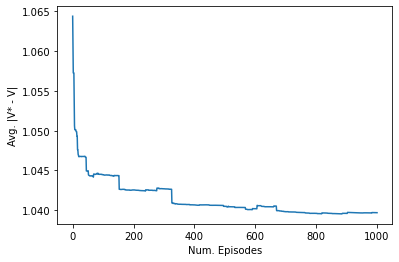

In [9]:
# collapse-hide

from typing import Union


def first_visit_mc_prediction(
    policy: Policy,
    env: RacetrackEnv,
    n_episodes: int,
    discount: float = 0.95,
    record_all_values: bool = False,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Predict value function corresponding to the policy by First-visit MC prediction"""
    n_states = env._max_width * env._max_height * 25
    v = np.zeros(n_states)
    all_values = []
    # Note that we have to have a list of returns for each state!
    # So the maximum memory usage would be Num.States x Num.Episodes
    all_returns = [[] for _ in range(n_states)]
    for i in range(n_episodes):
        if record_all_values:
            all_values.append(v.copy())
        state = env.reset()
        visited_states = [env.state_index(state)]
        received_rewards = []
        # Rollout the policy until the episode ends
        while True:
            # Sample an action from the policy
            action = policy(env.state_index(state))
            # Step the simulator
            state, reward, termination = env.step(state, action)
            visited_states.append(env.state_index(state))
            received_rewards.append(reward)
            if termination:
                break
        # Compute return
        traj_len = len(received_rewards)
        returns = np.zeros(traj_len)
        # Gt = Rt when t = T
        returns[-1] = received_rewards[-1]
        # Iterating from T - 2, T - 1, ..., to 0
        for t in reversed(range(traj_len - 1)):
            # Gt = Rt + γGt+1
            returns[t] = received_rewards[t] + discount * returns[t + 1]
        updated = set()
        # Update the value
        for i, state in enumerate(visited_states[: -1]):
            # If the state is already visited, skip it
            if state in updated:
                continue
            updated.add(state)
            all_returns[state].append(returns[i].item())
            # V(St) ← average(Returns(St))
            v[state] = np.mean(all_returns[state])
    return v, all_values


v, all_values = first_visit_mc_prediction(
    smalltrack_optimal_policy,
    smalltrack,
    1000,
    record_all_values=True,
)
value_diff = []
for i, mc_value in enumerate(all_values + [v]):
    value_diff.append(np.mean(np.abs(mc_value - vi_result.v)))
plt.plot(value_diff)
plt.xlabel("Num. Episodes")
plt.ylabel("Avg. |V* - V|")

It looks like that the difference between $V^*$ and the value function estimated by MC prediction converges after 600 steps, but it's still larger than $0$, because **$\pi^*$ doesn't visit all states**.
Let's plot the difference between value functions only on starting states.

(0.0, 0.5)

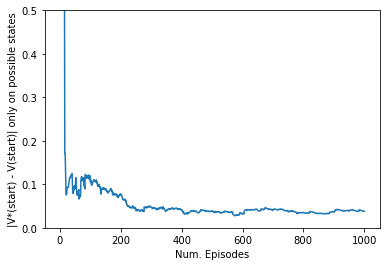

In [10]:
start_states = []
for x in range(1, 6):
    idx = smalltrack.state_index(State(position=np.array([6, x]), velocity=np.array([0, 0])))
    start_states.append(idx)
start_values = []
for i, mc_value in enumerate(all_values + [v]):
    start_values.append(np.mean(np.abs(mc_value - vi_result.v)[start_states]))
plt.plot(start_values)
plt.xlabel("Num. Episodes")
plt.ylabel("|V*(start) - V(start)| only on possible states")
plt.ylim((0.0, 0.5))

Here, we can confirm that the estimated value certainly converged close to 0.0, while fractuating a bit.
Note that the magnitude of fractuation is larger than the relative error we allowed for value iteration ($0.00002$), implying the difficulty of convergence.

## Monte-Carlo Control

Now we successfully estimate $V^\pi$ using Monte Carlo method, so then let's try to learn a sub-optimal $\pi$ directly using Monte Carlo method. In the textbook, three methods are introduced:
- Monte Carlo ES (Exploring Starts)
- On-policy first visit Monte Carlo Control
- Off-policy first visit Monte Carlo Control

Here, let's try all three methods and compare the resulting value functions.
However, we cannot naively implement the pseudo code in the textbook, due to a 'loop' problem.
Since the car that crashed into the wall is returned to a starting point, the episode length can be infinitte depending on a policy.
As a remedy for this problem, I limit the length of the episode as $H$.
Supposing that we ignore the future rewards smaller than $\epsilon$, how to set $H$?
Just by solving $\gamma^H R < \epsilon$, we get $H > \frac{\log \epsilon}{\log \gamma}$, which is about $270$ in case $\gamma = 0.95$ and $\epsilon = 0.000001$.

Below are the implementation of three methods.
A few notes about implementation:
- Monte Carlo ES requires a set of all possible states, which is implemented in `valid_states` function.
- For On-Policy MC, $\epsilon$ is decreased from 0.5 to 0.01
- We can use arbitary policy in Off-Policy MC, but I used the same $\epsilon$-soft policy as On-Policy MC.

In [24]:
# collapse-hide

def valid_states(env: RacetrackEnv) -> List[State]:
    states = []
    for y in range(env._max_height):
        for x in range(env._max_width):
            track = env._track[y][x]
            if track == env.WALL:
                continue
            for y_velocity in range(5):
                for x_velocity in range(5):
                    state = State(np.array([y, x]), np.array([y_velocity, x_velocity]))
                    if track != env.START and (x_velocity > 0 or y_velocity > 0):
                        states.append(state)
    return states


def mc_es(
    env: RacetrackEnv,
    n_episodes: int,
    discount: float = 0.95,
    record_all_values: bool = False,
    seed: int = 999,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Monte-Carlo Control with Exploring Starts"""
    n_states = env._max_width * env._max_height * 25
    n_actions = len(env._actions)
    random_state = np.random.RandomState(seed=seed)
    q = np.zeros((n_states, n_actions))
    pi = random_state.randint(9, size=n_states)
    all_values = []
    all_returns = [[[] for _ in range(n_actions)] for _ in range(n_states)]
    possible_starts = valid_states(env)
    max_episode_length = int(np.ceil(np.log(1e-6) / np.log(discount)))
    for i in range(n_episodes):
        if record_all_values:
            all_values.append(q.copy())
        state = possible_starts[random_state.choice(len(possible_starts))]
        visited_states = [env.state_index(state)]
        taken_actions = []
        received_rewards = []
        initial = True
        for _ in range(max_episode_length):
            if initial:
                # Randomly sample the first action
                action = random_state.randint(9)
                initial = False
            else:
                # Take an action following the policy
                action = pi[env.state_index(state)]
            taken_actions.append(action)
            # Step the simulator
            state, reward, termination = env.step(state, action)
            visited_states.append(env.state_index(state))
            received_rewards.append(reward)
            if termination:
                break
        # Compute return
        traj_len = len(received_rewards)
        returns = np.zeros(traj_len)
        # Gt = Rt when t = T
        returns[-1] = received_rewards[-1]
        # Iterating from T - 2, T - 1, ..., to 0
        for t in reversed(range(traj_len - 1)):
            # Gt = Rt + γGt+1
            returns[t] = received_rewards[t] + discount * returns[t + 1]
        updated = set()
        # Update the value
        for i, (state, action) in enumerate(zip(visited_states[:-1], taken_actions)):
            # If the state is already visited, skip it
            if (state, action) in updated:
                continue
            updated.add((state, action))
            all_returns[state][action].append(returns[i].item())
            # Q(St, At) ← average(Returns(St, At))
            q[state, action] = np.mean(all_returns[state][action])
            pi[state] = np.argmax(q[state])
    return q, all_values


def on_policy_fist_visit_mc(
    env: RacetrackEnv,
    n_episodes: int,
    discount: float = 0.95,
    epsilon: float = 0.1,
    epsilon_final: float = 0.1,
    record_all_values: bool = False,
    seed: int = 999,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """On-policy first visit Monte-Carlo"""

    n_states = env._max_width * env._max_height * 25
    n_actions = len(env._actions)
    random_state = np.random.RandomState(seed=seed)
    q = np.zeros((n_states, n_actions))
    pi = random_state.randint(9, size=n_states)
    all_values = []
    all_returns = [[[] for _ in range(n_actions)] for _ in range(n_states)]
    possible_starts = valid_states(env)
    max_episode_length = int(np.ceil(np.log(1e-6) / np.log(discount)))
    epsilon_decay = (epsilon - epsilon_final) / n_episodes
    for i in range(n_episodes):
        if record_all_values:
            all_values.append(q.copy())
        state = env.reset()
        visited_states = [env.state_index(state)]
        taken_actions = []
        received_rewards = []
        for _ in range(max_episode_length):
            # ε-soft policy
            if random_state.rand() < epsilon:
                action = random_state.randint(9)
            else:
                action = pi[env.state_index(state)]
            taken_actions.append(action)
            # Step the simulator
            state, reward, termination = env.step(state, action)
            visited_states.append(env.state_index(state))
            received_rewards.append(reward)
            if termination:
                break
        # Below code is the same as mc_es
        # Compute return
        traj_len = len(received_rewards)
        returns = np.zeros(traj_len)
        # Gt = Rt when t = T
        returns[-1] = received_rewards[-1]
        # Iterating from T - 2, T - 1, ..., to 0
        for t in reversed(range(traj_len - 1)):
            # Gt = Rt + γGt+1
            returns[t] = received_rewards[t] + discount * returns[t + 1]
        updated = set()
        # Update the value
        for i, (state, action) in enumerate(zip(visited_states[:-1], taken_actions)):
            # If the state is already visited, skip it
            if (state, action) in updated:
                continue
            updated.add((state, action))
            all_returns[state][action].append(returns[i].item())
            # Q(St, At) ← average(Returns(St, At))
            q[state, action] = np.mean(all_returns[state][action])
            pi[state] = np.argmax(q[state])
        epsilon -= epsilon_decay
    return q, all_values


def off_policy_mc(
    env: RacetrackEnv,
    n_episodes: int,
    discount: float = 0.95,
    record_all_values: bool = False,
    epsilon: float = 0.1,
    epsilon_final: float = 0.1,
    seed: int = 999,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Off-policy MC control"""

    n_states = env._max_width * env._max_height * 25
    n_actions = len(env._actions)
    random_state = np.random.RandomState(seed=seed)
    q = np.zeros((n_states, n_actions))
    c = np.zeros_like(q)
    pi = np.argmax(q, axis=1)
    all_values = []
    possible_starts = valid_states(env)
    max_episode_length = int(np.ceil(np.log(1e-6) / np.log(discount)))
    epsilon_decay = (epsilon - epsilon_final) / n_episodes
    for i in range(n_episodes):
        if record_all_values:
            all_values.append(q.copy())
        state = env.reset()
        visited_states = [env.state_index(state)]
        taken_actions = []
        received_rewards = []
        acted_optimally = []
        for _ in range(max_episode_length):
            # ε-soft policy
            if random_state.rand() < epsilon:
                action = random_state.randint(9)
            else:
                action = pi[env.state_index(state)]
            acted_optimally.append(action == pi[env.state_index(state)])
            taken_actions.append(action)
            # Step the simulator
            state, reward, termination = env.step(state, action)
            visited_states.append(env.state_index(state))
            received_rewards.append(reward)
            if termination:
                break
        g = 0
        w = 1.0
        for i, (state, action) in enumerate(zip(visited_states[:-1], taken_actions)):
            g = discount * g + received_rewards[i]
            c[state, action] += w
            q[state, action] += w / c[state, action] * (g - q[state, action])
            pi[state] = np.argmax(q[state])
            if action == pi[state]:
                break
            else:
                if acted_optimally:
                    w *= 1.0 - epsilon + epsilon / n_actions
                else:
                    w *= epsilon / n_actions
        epsilon -= epsilon_decay
    return q, all_values


mces_result = mc_es(smalltrack, 3000, record_all_values=True)
on_mc_result = on_policy_fist_visit_mc(
    smalltrack,
    3000,
    epsilon=0.5,
    epsilon_final=0.01,
    record_all_values=True,
)
off_mc_result = off_policy_mc(
    smalltrack,
    3000,
    epsilon=0.5,
    epsilon_final=0.01,
    record_all_values=True,
)

Let's plot the results. Here I plotted the difference from the optimal value function and the number of states that the policy choices the optimal action.

Text(0.5, 1.0, 'Num. of optimal actions')

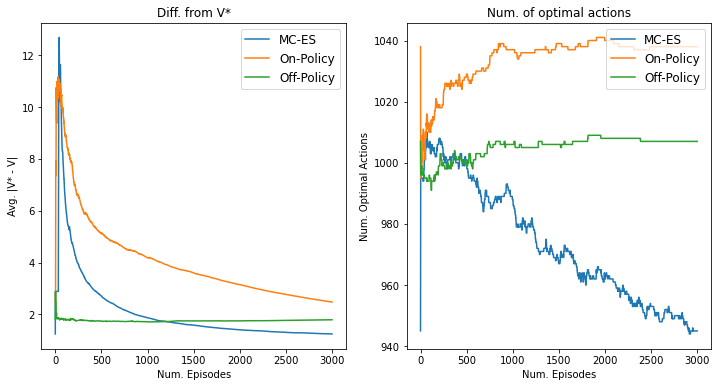

In [27]:
def value_diff(q_values: List[np.ndarray]) -> List[float]:
    diffs = []
    for i, q in enumerate(q_values):
        diff = np.abs(np.max(q, axis=-1) - vi_result.v)[start_states]
        diffs.append(np.mean(diff))
    return diffs


def n_optimal_actions(q_values: List[np.ndarray]) -> List[int]:
    n_optimal = []
    optimal_actions = np.argmax(vi_result.q, axis=-1)
    for i, q in enumerate(q_values):
        greedy = np.argmax(q, axis=-1)
        n_optimal.append(np.sum(greedy == optimal_actions))
    return n_optimal


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mc_es_value_diff = value_diff([mces_result[0]] + mces_result[1])
on_mc_value_diff = value_diff([on_mc_result[0]] + on_mc_result[1])
off_mc_value_diff = value_diff([off_mc_result[0]] + off_mc_result[1])
ax1.plot(mc_es_value_diff, label="MC-ES")
ax1.plot(on_mc_value_diff, label="On-Policy")
ax1.plot(off_mc_value_diff, label="Off-Policy")
ax1.set_xlabel("Num. Episodes")
ax1.set_ylabel("Avg. |V* - V|")
ax1.set_title("Diff. from V*")
mc_es_nopt = n_optimal_actions([mces_result[0]] + mces_result[1])
on_mc_nopt =  n_optimal_actions([on_mc_result[0]] + on_mc_result[1])
off_mc_nopt =  n_optimal_actions([off_mc_result[0]] + off_mc_result[1])
ax1.legend(fontsize=12, loc="upper right")
ax2.plot(mc_es_nopt, label="MC-ES")
ax2.plot(on_mc_nopt, label="On-Policy")
ax2.plot(off_mc_nopt, label="Off-Policy")
ax2.set_xlabel("Num. Episodes")
ax2.set_ylabel("Num. Optimal Actions")
ax2.legend(fontsize=12, loc="upper right")
ax2.set_title("Num. of optimal actions")

Some observations from the results:
- On-Policy MC converges to the optimal policy the fastest, though the convergence of its value function is the slowest
- MC-ES struggles to distinguish optimal and non-optimal actions at some states, probably because of the lack of exploration during an episode.
- Compared to MC-ES and On-Policy MC, the peak of value differences of Off-Policy MC is much milder.
  - A randomly initialized policy is often caught in a loop and cannot reach to the goal. The value of such a policy is really small ($-1  -1 * 0.95 - 1 * 0.95^2 - ... \approx -20$). However, Off-Policy MC uses important sampling to decay the rewards by uncertain actions, resulting the smaller value differences.
  
Here I visualized sampled plays from all three methods.
On-Policy MC looks the most efficient.

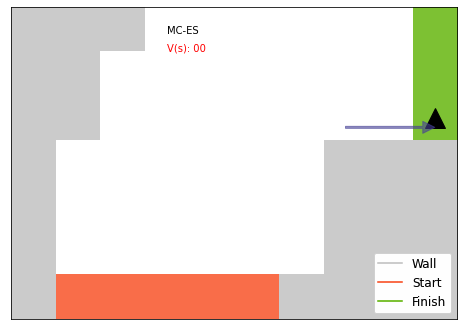

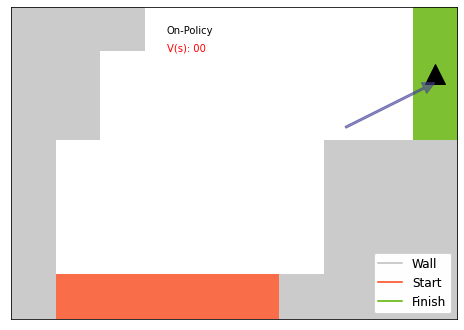

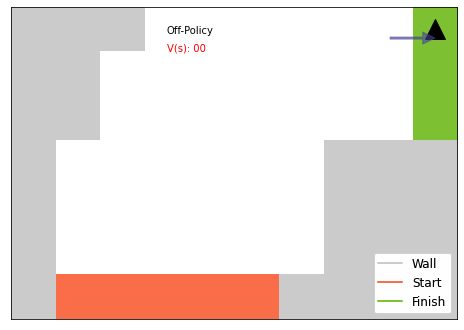

In [33]:
for q, name in zip([mces_result[0], on_mc_result[0], off_mc_result[0]], ["MC-ES", "On-Policy", "Off-Policy"]):
    display(show_rollout(smalltrack, lambda i: np.argmax(q[i]), np.argmax(q, axis=-1), name))